Timestep k=1
State Estimate Before EKF=[4.51  0.01  0.003]
Observation=[4.721 0.143 0.006]
State Estimate After EKF=[ 4.584  0.043 -0.016]

Timestep k=2
State Estimate Before EKF=[ 9.093 -0.021 -0.013]
Observation=[9.353 0.284 0.007]
State Estimate After EKF=[ 9.208  0.121 -0.025]

Timestep k=3
State Estimate Before EKF=[13.716  0.017 -0.022]
Observation=[14.773  0.422  0.009]
State Estimate After EKF=[14.324  0.224 -0.028]

Timestep k=4
State Estimate Before EKF=[18.832  0.109 -0.025]
Observation=[18.246  0.555  0.011]
State Estimate After EKF=[18.427  0.341 -0.027]

Timestep k=5
State Estimate Before EKF=[22.935  0.228 -0.024]
Observation=[22.609  0.715  0.012]
State Estimate After EKF=[22.69   0.486 -0.027]



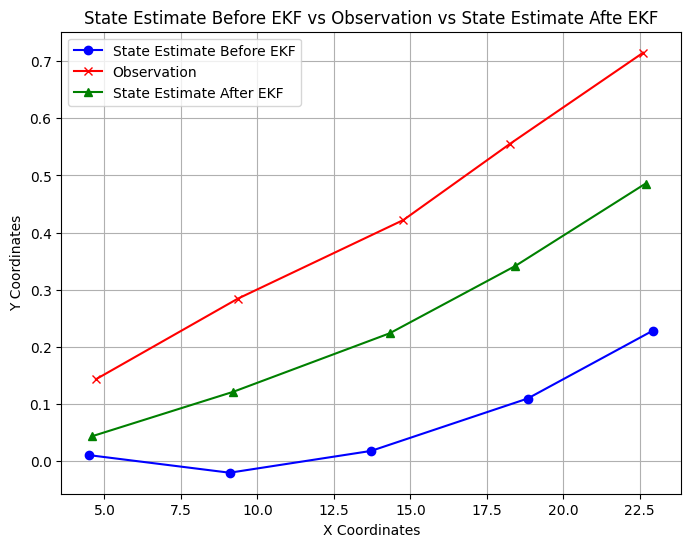

In [ ]:
# Description: Extended Kalman Filter example (two-wheeled mobile robot)
# Reference: https://automaticaddison.com/extended-kalman-filter-ekf-with-python-code-example/

import numpy as np
import matplotlib.pyplot as plt

# Supress scientific notation when printing NumPy arrays
np.set_printoptions(precision=3,suppress=True)

# A matrix
# 3x3 matrix -> number of states x number of states matrix
# Expresses how the state of the system [x,y,yaw] changes
# from k-1 to k when no control command is executed.
# Typically a robot on wheels only drives when the wheels are told to turn.
# For this case, A is the identity matrix.

A_k_minus_1 = np.array([[1.0,  0,   0],
                                                [  0,1.0,   0],
                                                [  0,  0, 1.0]])

# Noise applied to the forward kinematics. This is a vector
# with the number of elements equal to the number of states
process_noise_v_k_minus_1 = np.array([0.01,0.01,0.003])

# State model noise covariance matrix Q_k
# Q is a square matrix that has the same number of rows as states.
Q_k = np.array([[1.0,   0,   0],
                                [  0, 1.0,   0],
                                [  0,   0, 1.0]])

# Measurement matrix H_k
# Used to convert the predicted state estimate at time k
# into predicted sensor measurements at time k.
# In this case, H will be the identity matrix since the
# estimated state maps directly to state measurements from the
# odometry data [x, y, yaw]
# H has the same number of rows as sensor measurements
# and same number of columns as states.
H_k = np.array([[1.0,  0,   0],
                                [  0,1.0,   0],
                                [  0,  0, 1.0]])

# Sensor measurement noise covariance matrix R_k
# Has the same number of rows and columns as sensor measurements.
# If we are sure about the measurements, R will be near zero.
R_k = np.array([[1.0,   0,    0],
                                [  0, 1.0,    0],
                                [  0,    0, 1.0]])

# Sensor noise. This is a vector with the
# number of elements equal to the number of sensor measurements.
sensor_noise_w_k = np.array([0.07,0.07,0.04])

def getB(yaw, deltak):
    """
    Calculates and returns the B matrix
    3x2 matix -> number of states x number of control inputs
    The control inputs are the forward speed and the
    rotation rate around the z axis from the x-axis in the
    counterclockwise direction.
    [v,yaw_rate]
    Expresses how the state of the system [x,y,yaw] changes
    from k-1 to k due to the control commands (i.e. control input).
    :param yaw: The yaw angle (rotation angle around the z axis) in rad
    :param deltak: The change in time from time step k-1 to k in sec
    """
    B = np.array([  [np.cos(yaw)*deltak, 0],
                                    [np.sin(yaw)*deltak, 0],
                                    [0, deltak]])
    return B


def ekf(z_k_observation_vector, state_estimate_k_minus_1,
        control_vector_k_minus_1, P_k_minus_1, dk):
    """
    Extended Kalman Filter. Fuses noisy sensor measurement to
    create an optimal estimate of the state of the robotic system.

    INPUT
        :param z_k_observation_vector The observation from the Odometry
            3x1 NumPy Array [x,y,yaw] in the global reference frame
            in [meters,meters,radians].
        :param state_estimate_k_minus_1 The state estimate at time k-1
            3x1 NumPy Array [x,y,yaw] in the global reference frame
            in [meters,meters,radians].
        :param control_vector_k_minus_1 The control vector applied at time k-1
            3x1 NumPy Array [v,v,yaw rate] in the global reference frame
            in [meters per second,meters per second,radians per second].
        :param P_k_minus_1 The state covariance matrix estimate at time k-1
            3x3 NumPy Array
        :param dk Time interval in seconds

    OUTPUT
        :return state_estimate_k near-optimal state estimate at time k
            3x1 NumPy Array ---> [meters,meters,radians]
        :return P_k state covariance_estimate for time k
            3x3 NumPy Array
    """
    ######################### Predict #############################
    # Predict the state estimate at time k based on the state
    # estimate at time k-1 and the control input applied at time k-1.
    state_estimate_k = A_k_minus_1 @ (
            state_estimate_k_minus_1) + (
            getB(state_estimate_k_minus_1[2],dk)) @ (
            control_vector_k_minus_1) + (
            process_noise_v_k_minus_1)

    print(f'State Estimate Before EKF={state_estimate_k}')

    coordinates = tuple(state_estimate_k)

    # Predict the state covariance estimate based on the previous
    # covariance and some noise
    P_k = A_k_minus_1 @ P_k_minus_1 @ A_k_minus_1.T + (
            Q_k)

    ################### Update (Correct) ##########################
    # Calculate the difference between the actual sensor measurements
    # at time k minus what the measurement model predicted
    # the sensor measurements would be for the current timestep k.
    measurement_residual_y_k = z_k_observation_vector - (
            (H_k @ state_estimate_k) + (
            sensor_noise_w_k))

    print(f'Observation={z_k_observation_vector}')

    # Calculate the measurement residual covariance
    S_k = H_k @ P_k @ H_k.T + R_k

    # Calculate the near-optimal Kalman gain
    # We use pseudoinverse since some of the matrices might be
    # non-square or singular.
    K_k = P_k @ H_k.T @ np.linalg.pinv(S_k)

    # Calculate an updated state estimate for time k
    state_estimate_k = state_estimate_k + (K_k @ measurement_residual_y_k)

    # Update the state covariance estimate for time k
    P_k = P_k - (K_k @ H_k @ P_k)

    # Print the best (near-optimal) estimate of the current state of the robot
    print(f'State Estimate After EKF={state_estimate_k}')

    # return state_estimate_k, P_k, coordinates
    return state_estimate_k, P_k, coordinates



def main():

    # We start at time k=1
    k = 1

    # Time interval in seconds
    dk = 1

    # Create a list of sensor observations at successive timesteps
    # Each list within z_k is an observation vector.
    z_k = np.array([[4.721,0.143,0.006], # k=1
                    [9.353,0.284,0.007], # k=2
                    [14.773,0.422,0.009],# k=3
                    [18.246,0.555,0.011], # k=4
                    [22.609,0.715,0.012]])# k=5

    # The estimated state vector at time k-1 in the global reference frame.
    # [x_k_minus_1, y_k_minus_1, yaw_k_minus_1]
    # [meters, meters, radians]
    state_estimate_k_minus_1 = np.array([0.0,0.0,0.0])

    # The control input vector at time k-1 in the global reference frame.
    # [v, yaw_rate]
    # [meters/second, radians/second]
    # In the literature, this is commonly u.
    # Because there is no angular velocity and the robot begins at the
    # origin with a 0 radians yaw angle, this robot is traveling along
    # the positive x-axis in the global reference frame.
    control_vector_k_minus_1 = np.array([4.5,0.0])

    # State covariance matrix P_k_minus_1
    # This matrix has the same number of rows (and columns) as the
    # number of states (i.e. 3x3 matrix). P is sometimes referred
    # to as Sigma in the literature. It represents an estimate of
    # the accuracy of the state estimate at time k made using the
    # state transition matrix. We start off with guessed values.
    P_k_minus_1 = np.array([[0.1,  0,   0],
                                                    [  0,0.1,   0],
                                                    [  0,  0, 0.1]])
    # Initialize x and y coordinates arrays outside the loop
    x_coordinates = np.array([])
    y_coordinates = np.array([])

    # Initialize x and y coordinates arrays for observations
    x_observation_coordinates = np.array([])
    y_observation_coordinates = np.array([])

    # Initialize x and y coordinates arrays for state estimates after EKF
    x_state_estimate_coordinates = np.array([])
    y_state_estimate_coordinates = np.array([])


    # Start at k=1 and go through each of the 5 sensor observations,
    # one at a time.
    # We stop right after timestep k=5 (i.e. the last sensor observation)
    for k, obs_vector_z_k in enumerate(z_k,start=1):

        # Print the current timestep
        print(f'Timestep k={k}')

        # Run the Extended Kalman Filter and store the near-optimal state,
        #covariance estimates
        optimal_state_estimate_k, covariance_estimate_k, coordinates = ekf(
            obs_vector_z_k, # Most recent sensor measurement
            state_estimate_k_minus_1, # Our most recent estimate of the state
            control_vector_k_minus_1, # Our most recent control input
            P_k_minus_1, # Our most recent state covariance matrix
            dk # Time interval
        )

        # Update the x and y coordinates for state estimates before EKF
        x_coordinates = np.append(x_coordinates, coordinates[0])
        y_coordinates = np.append(y_coordinates, coordinates[1])

        # Extract x and y coordinates for observations
        x_observation_coordinates = np.append(x_observation_coordinates, obs_vector_z_k[0])
        y_observation_coordinates = np.append(y_observation_coordinates, obs_vector_z_k[1])

        # Extract x and y coordinates for state estimates after EKF
        x_state_estimate_coordinates = np.append(x_state_estimate_coordinates, optimal_state_estimate_k[0])
        y_state_estimate_coordinates = np.append(y_state_estimate_coordinates, optimal_state_estimate_k[1])

        # Get ready for the next timestep by updating the variable values
        state_estimate_k_minus_1 = optimal_state_estimate_k
        P_k_minus_1 = covariance_estimate_k

        # Print a blank line
        print()


    plt.figure(figsize=(8, 6))
    plt.plot(x_coordinates, y_coordinates, marker='o', linestyle='-', color='b', label='State Estimate Before EKF')
    plt.plot(x_observation_coordinates, y_observation_coordinates, marker='x', linestyle='-', color='r', label='Observation')
    plt.plot(x_state_estimate_coordinates, y_state_estimate_coordinates, marker='^', linestyle='-', color='g', label='State Estimate After EKF')
    plt.title('State Estimate Before EKF vs Observation vs State Estimate Afte EKF')
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.legend()
    plt.grid(True)
    plt.show()

# Program starts running here with the main method
main()